In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import joblib

In [2]:
# Load the saved CNN model
cnn_model = load_model(r"C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\cnn_model.h5")
cnn_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

# Freeze CNN layers
for layer in cnn_model.layers:
    layer.trainable = False


In [3]:
# Image directories
train_dir = r"K:\PROJECT\ORGANISED DATASET\train"
test_dir = r"K:\PROJECT\ORGANISED DATASET\test"

In [4]:
# Image preprocessing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)

Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [5]:
# Feature extraction
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(train_generator, cnn_model)
test_features, test_labels = extract_features(test_generator, cnn_model)

54/54 [==============================] - 217s 4s/step


In [6]:
# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

print(f"Original feature dimensions: {train_features.shape[1]}")

Original feature dimensions: 86528


In [7]:
# Apply PCA
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

print(f"Reduced feature dimensions (PCA): {train_features_pca.shape[1]}")

Reduced feature dimensions (PCA): 389


In [8]:
from sklearn.model_selection import GridSearchCV
# Hyperparameter tuning for KNN
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 15, 21], 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_features_pca, train_labels)

# Best KNN model
best_knn = grid_search.best_estimator_
print(f"Best K value: {grid_search.best_params_['n_neighbors']}, Weights: {grid_search.best_params_['weights']}")


Best K value: 21, Weights: distance


In [13]:
# Predict on test set
test_predictions = best_knn.predict(test_features_pca)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy with PCA: {accuracy:.4f}")

Test Accuracy with PCA: 0.8561


In [14]:
# Classification report
print("Classification Report with PCA:")
print(classification_report(test_labels, test_predictions, target_names=test_generator.class_indices.keys()))


Classification Report with PCA:
              precision    recall  f1-score   support

      BENIGN       0.87      0.64      0.74       542
   MALIGNANT       0.85      0.96      0.90      1182

    accuracy                           0.86      1724
   macro avg       0.86      0.80      0.82      1724
weighted avg       0.86      0.86      0.85      1724



In [15]:
# Save the trained KNN model and PCA
knn_model_path = r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\knn_model_with_pca.pkl'
pca_model_path = r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl'
scaler_model_path = r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\scaler_with_pca.pkl'

joblib.dump(best_knn, knn_model_path)
joblib.dump(pca, pca_model_path)
joblib.dump(scaler, scaler_model_path)

print(f"KNN model saved at {knn_model_path}")
print(f"PCA model saved at {pca_model_path}")
print(f"Scaler saved at {scaler_model_path}")

KNN model saved at C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\knn_model_with_pca.pkl
PCA model saved at C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl
Scaler saved at C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\scaler_with_pca.pkl


1/1 [==============================] - 0s 74ms/step


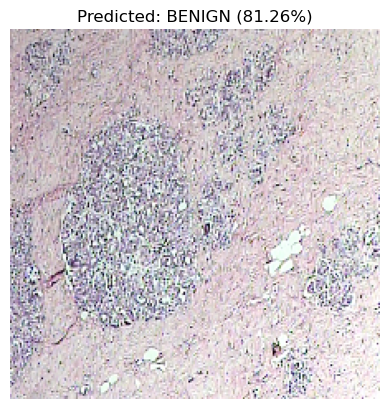

Prediction Probabilities:
BENIGN: 0.81
MALIGNANT: 0.19


In [16]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained models
cnn_model = load_model(r"C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\cnn_model.h5")
cnn_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

scaler = joblib.load(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\scaler_with_pca.pkl')
pca = joblib.load(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl')
knn_classifier = joblib.load(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\knn_model_with_pca.pkl')

# Class labels mapping
class_indices = {'BENIGN': 0, 'MALIGNANT': 1}
reverse_class_indices = {v: k for k, v in class_indices.items()}

def predict_image(image_path):
    """Predict the class of a single image using the trained CNN+PCA+KNN model."""
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using CNN
    features = cnn_model.predict(img_array)
    
    # Apply scaling and PCA transformation
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)
    
    # Predict using KNN
    prediction = knn_classifier.predict(features_pca)
    probabilities = knn_classifier.predict_proba(features_pca)[0]

    # Get predicted class and confidence
    predicted_class = reverse_class_indices[prediction[0]]
    confidence = max(probabilities)

    # Display image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
    plt.show()

    # Print probability scores
    print("Prediction Probabilities:")
    for class_label, prob in zip(reverse_class_indices.values(), probabilities):
        print(f"{class_label}: {prob:.2f}")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\tubular_adenoma\SOB_B_TA_14-13200\40X\SOB_B_TA-14-13200-40-015.png"
predict_image(image_path)


1/1 [==============================] - 0s 76ms/step


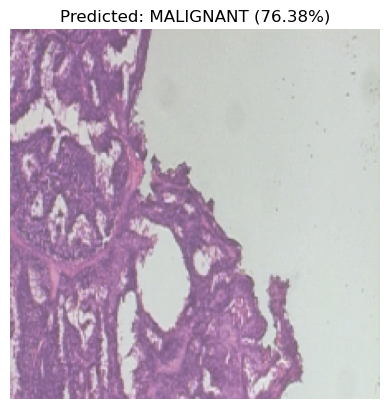

Prediction Probabilities:
BENIGN: 0.24
MALIGNANT: 0.76


In [17]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained models
cnn_model = load_model(r"C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\cnn_model.h5")
cnn_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

scaler = joblib.load(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\scaler_with_pca.pkl')
pca = joblib.load(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl')
knn_classifier = joblib.load(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\knn_model_with_pca.pkl')

# Class labels mapping
class_indices = {'BENIGN': 0, 'MALIGNANT': 1}
reverse_class_indices = {v: k for k, v in class_indices.items()}

def predict_image(image_path):
    """Predict the class of a single image using the trained CNN+PCA+KNN model."""
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using CNN
    features = cnn_model.predict(img_array)
    
    # Apply scaling and PCA transformation
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)
    
    # Predict using KNN
    prediction = knn_classifier.predict(features_pca)
    probabilities = knn_classifier.predict_proba(features_pca)[0]

    # Get predicted class and confidence
    predicted_class = reverse_class_indices[prediction[0]]
    confidence = max(probabilities)

    # Display image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
    plt.show()

    # Print probability scores
    print("Prediction Probabilities:")
    for class_label, prob in zip(reverse_class_indices.values(), probabilities):
        print(f"{class_label}: {prob:.2f}")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\papillary_carcinoma\SOB_M_PC_14-9146\40X\SOB_M_PC-14-9146-40-007.png"
predict_image(image_path)
